In [1]:
import xarray as xr
import now
import numpy as np
import dask as da
import scipy.stats as stats
import time
import pandas as pd
import cartopy.crs as ccrs
import seaborn as sns
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
from cartopy import config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


<Client: scheduler='inproc://10.0.64.2/15082/1' processes=1 cores=8>

In [3]:
# Plotting stuff
plt.rcParams["figure.figsize"] = [16,9]
sns.set()

In [4]:
# Importing MHW files
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
futMHW = xr.open_dataarray(localDir + 'mhws_NOWFutRun.nc')
pastMHW = xr.open_dataarray(localDir + 'mhws_NOWPastRun.nc')

In [5]:
# Defining chunk sizes
x_chunk = 120
y_chunk = 90
t_chunk = 365

In [6]:
futMHW = futMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})
pastMHW = pastMHW.chunk({'x' : x_chunk, 'y' : y_chunk, 'time_counter' : t_chunk})

Index: 
* Max Severity 
* Max SSTA 
* Number of MHW Days 
* All plotted together, Changes in Mean state

## Finding mean of the max severity per year in future and past MHWs
This removes the edges of the model, which are known to be inaccurate. Additonally I removed an extra amount from the top of the model, which seemed to give some weird results.

In [93]:
%%time
maxFutSev= futMHW.isel(x = slice(5,-5), y = slice(5,-50)).groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()

CPU times: user 48 s, sys: 1min, total: 1min 48s
Wall time: 4min 11s


In [94]:
%%time 
maxPastSev = pastMHW.isel(x = slice(5,-5), y = slice(5,-50)).groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()

CPU times: user 1min 2s, sys: 53.7 s, total: 1min 55s
Wall time: 6min 5s


In [95]:
# Replaces land masses with nan as opposed to 0 value
maxPastSev = xr.where(maxPastSev == 0, np.nan, maxPastSev)
maxFutSev = xr.where(maxFutSev == 0, np.nan, maxFutSev)

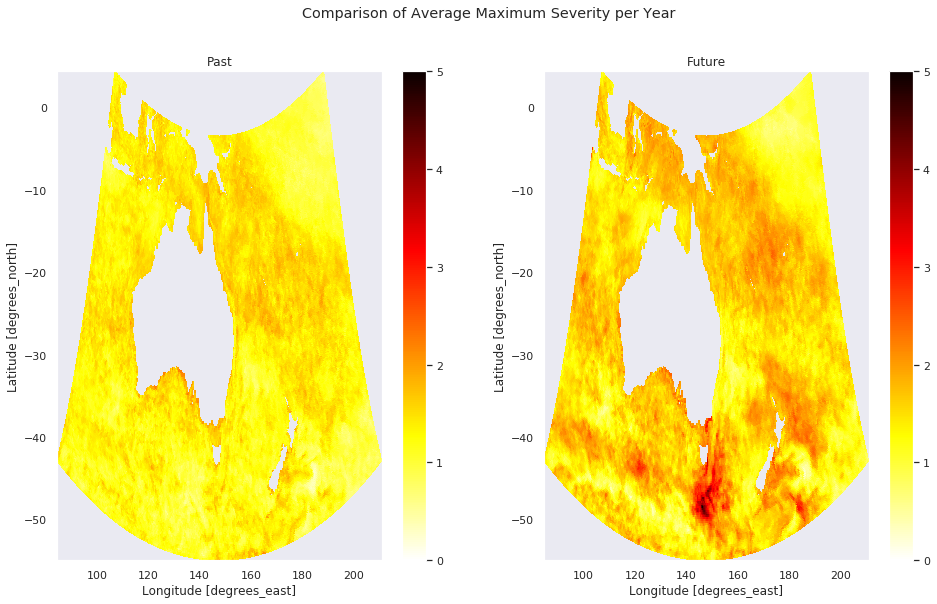

In [97]:
vmin = 0; vmax = 5;
f, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,9))
f.suptitle('Comparison of Average Maximum Severity per Year')
maxPastSev.plot(cmap = 'hot_r', ax = ax1, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);
maxFutSev.plot(cmap = 'hot_r',ax = ax2, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);

ax1.set_title('Past')

ax2.set_title('Future');

In [31]:
# Difference between past and future maximums. Also ensures that landmasses stay as nan.
max_diff = maxFutSev - maxPastSev

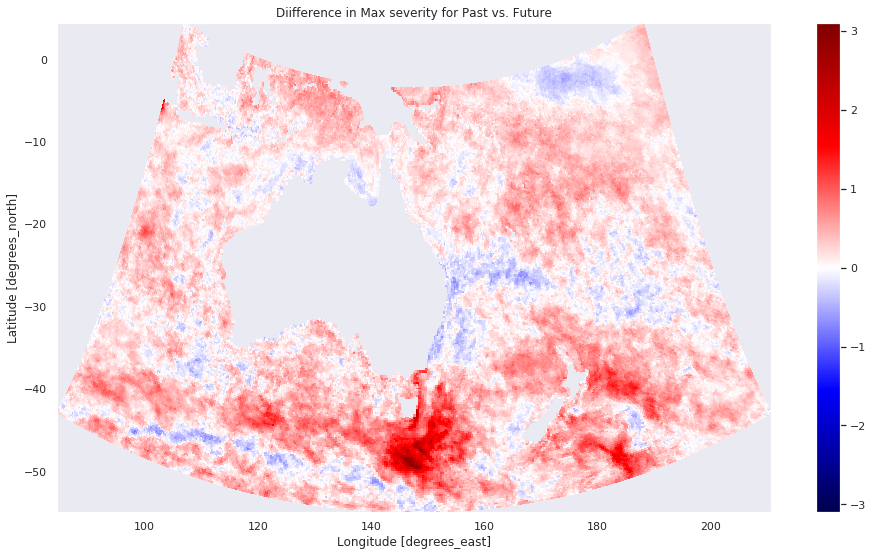

In [32]:
max_diff.plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic');
plt.title('Diifference in Max severity for Past vs. Future');

In [65]:
grid = xr.open_dataset('/g/data1/e14/gs9353/NOW_OUTPUTS/MESH/mesh_mask_cordex24.nc')

In [100]:
gridx = grid['e1t'].isel(t= 0)
gridy = grid['e2t'].isel(t= 0)

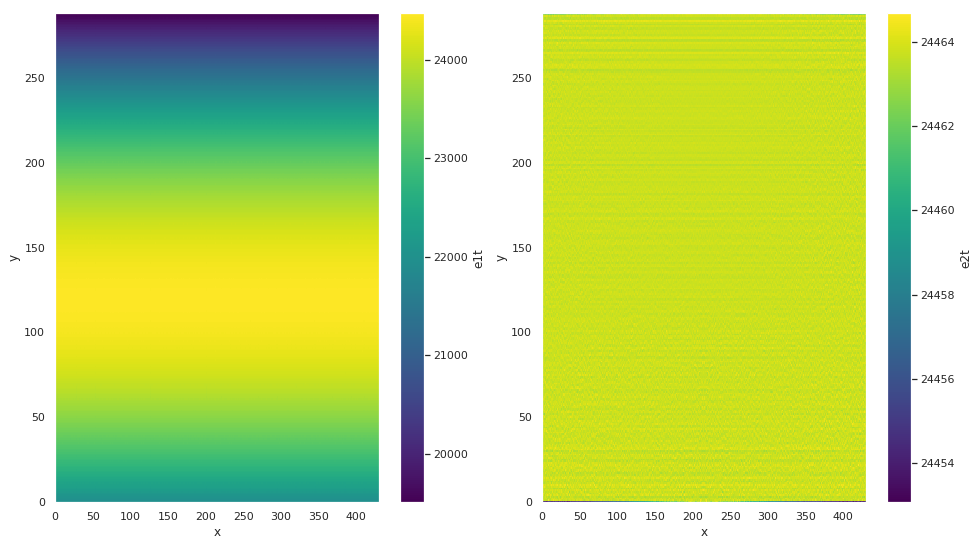

In [105]:
f, ax = plt.subplots(1,2)
gridx.plot(ax = ax[0]);
gridy.plot(ax = ax[1]);

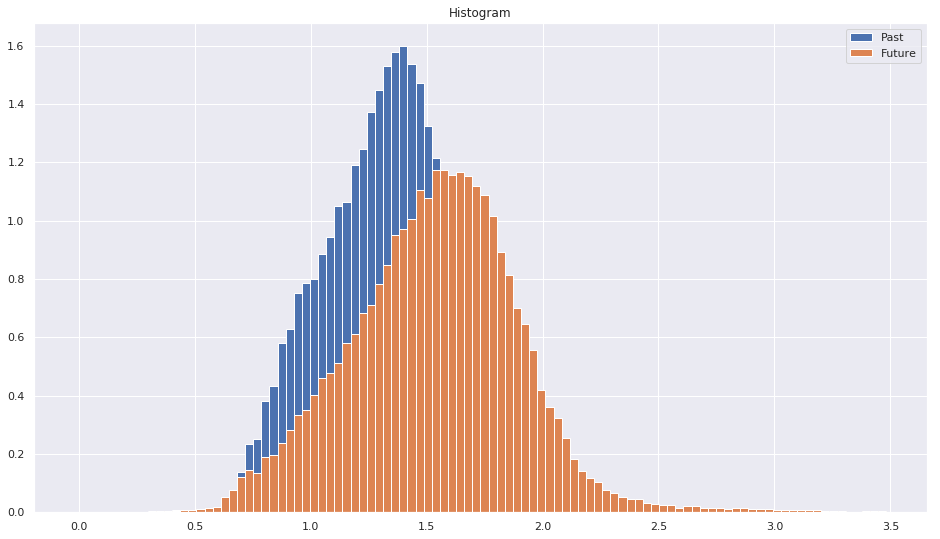

In [43]:
# Plots the frequencies/frequency density for each severity. 
bins = np.linspace(0,3.5,101)

# True if plotting densities, false if you want just frequency
pltDens = True

#f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

maxPastSev.plot.hist(align = 'left', bins = bins, density = pltDens, label = 'Past')#, ax = ax1);
maxFutSev.plot.hist(align = 'left',  bins = bins, density = pltDens, label = 'Future')#, ax = ax2);
plt.legend()
'''
ax1.set_title('Past Severity')
ax1.grid(True)
ax1.set_xlabel('Severity')

ax2.set_title('Future Severity');
ax2.grid(True);
ax2.set_xlabel('Severity');
''';

In [404]:
maxPastSev_seas = pastMHW.groupby('time_counter.season').max(dim = 'time_counter').compute()
maxFutSev_seas = futMHW.groupby('time_counter.season').max(dim = 'time_counter').compute()

In [405]:
maxSev_diff_seas = maxFutSev_seas - maxPastSev_seas

seasons = {0:'Summer', 1:'Autumn', 2:'Winter', 3:'Spring'}

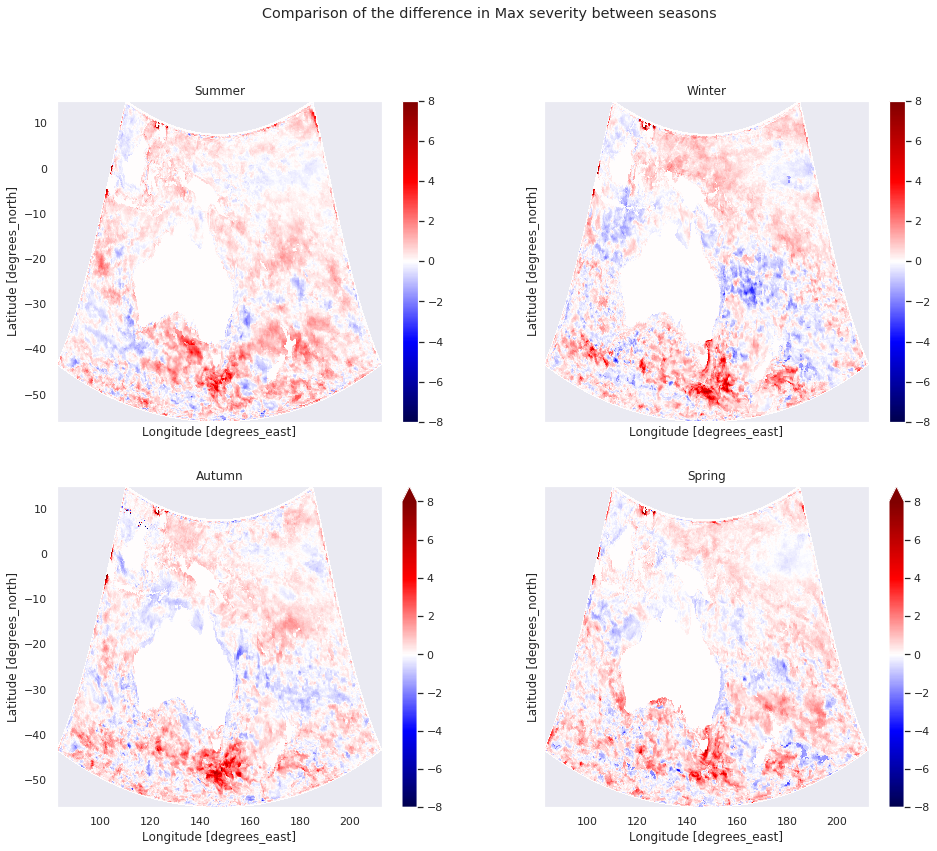

In [482]:
f, axes = plt.subplots(2,2, figsize = (16, 13), sharex = True, sharey = True)
f.suptitle('Comparison of the difference in Max severity between seasons')
vmin, vmax = (-8, 8)
i = 0
for ax in axes.flat:
    maxSev_diff_seas[i].plot(cmap = 'seismic', x='nav_lon', y ='nav_lat', ax = ax, vmin = vmin, vmax = vmax);
    ax.set_title(seasons[i])
    i += 1 
    
# Looking for positve values (implies future shallower than past)
plt.savefig('/home/561/rm6294/Documents/Statisitics_Plots/maxSev_seas.png')

### Calculating statistics for maximum Severity

In [98]:
# Calculating interquartile range
past_iqr = (maxPastSev.quantile(q = 0.75) - maxPastSev.quantile(q = 0.25)).data
fut_iqr = (maxFutSev.quantile(q = 0.75) - maxFutSev.quantile(q = 0.25)).data

In [45]:
# Comparing statistics
print("Past: std =", np.round(maxPastSev.std().data, 2), ", var =", np.round(maxPastSev.var().data,2),
      ", mean =", np.round(maxPastSev.mean().data,2), ", median =", np.round(maxPastSev.median().data,2),
     ", iqr =", np.round(past_iqr, 2))
print("Futu: std =", np.round(maxFutSev.std().data, 2), ", var =", np.round(maxFutSev.var().data,2),
     ", mean =", np.round(maxFutSev.mean().data,2),  ", median =", np.round(maxFutSev.median().data,2),
     ", iqr =", np.round(fut_iqr, 2))

Past: std = 0.25 , var = 0.06 , mean = 1.3 , median = 1.33 , iqr = 0.36
Futu: std = 0.38 , var = 0.14 , mean = 1.56 , median = 1.57 , iqr = 0.47


## Max SSTA

In [36]:
cfg = 'present_vs_future.ini'
# mld = Mixed Layer Depth
sst = now.io.open_nemo_griddata_from_zarr(cfg, grid='T')['tos']

In [37]:
pClim = xr.open_dataarray(localDir + 'pastClimRep.nc')
fClim = xr.open_dataarray(localDir + 'futureClimRep.nc')

In [38]:
cfg = 'present_vs_future.ini'
# mld = Mixed Layer Depth
mld = now.io.open_nemo_griddata_from_zarr(cfg, grid='T')['mldr10_1']

In [39]:
sstPast = sst.sel(simulation = 'Present')
sstFut = sst.sel(simulation = 'Future')

In [40]:
# Finding anomaly
sstaPast = sstPast.chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk}) - pClim.chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk})
sstaFut = sstFut.chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk}) - fClim.chunk({'x': x_chunk, 'y':y_chunk, 'time_counter':t_chunk})

In [41]:
%%time
# Finding max SSTA
maxFutSSTA = sstaFut.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute() 

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
distributed.worker - WARNING -  Compute Failed
Function:  getter
args:      (ImplicitToExplicitIndexingAdapter(array=LazilyOuterIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7f8ff2c0add8>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None), slice(None, None, None))))), (0, slice(3750, 4000, None), slice(0, 289, None), slice(0, 431, None)))
kwargs:    {}
Exception: RuntimeError('error during blosc decompression: -1',)



RuntimeError: error during blosc decompression: -1

In [43]:
max

<xarray.DataArray (y: 234, x: 421)>
array([[2.261044, 2.136186, 2.029487, ..., 1.440593, 1.460573, 1.477499],
       [2.247013, 2.088847, 1.976654, ..., 1.425652, 1.428059, 1.465487],
       [2.168956, 1.976546, 1.855098, ..., 1.474134, 1.474053, 1.479543],
       ...,
       [1.372885, 1.429555, 1.420573, ..., 1.117704, 1.12956 , 1.121821],
       [1.428644, 1.471979, 1.470984, ..., 1.097086, 1.111572, 1.102199],
       [1.413145, 1.454206, 1.478058, ..., 1.084076, 1.087884, 1.095567]],
      dtype=float32)
Coordinates:
    nav_lat  (y, x) float32 -42.806076 -42.903023 ... 4.200698 4.2713823
Dimensions without coordinates: y, x

In [44]:
%%time
maxPastSSTA = sstaPast.groupby('time_counter.year').max(dim = 'time_counter').mean(dim = 'year').compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 1min 36s, sys: 3min 50s, total: 5min 26s
Wall time: 2min 44s


In [48]:
# Replaces land masses with nan as opposed to 0 value
maxPastSSTA = xr.where(maxPastSSTA == 0, np.nan, maxPastSSTA)
maxFutSSTA = xr.where(maxFutSSTA == 0, np.nan, maxFutSSTA)

In [47]:
# This removes the edges of the model, which are known to be inaccurate. Additonally I removed an extra amount from the 
# top of the model, which seemed to give some weird results.
maxPastSSTA = maxPastSSTA.isel(x = slice(5,-5), y = slice(5,-50))
maxFutSSTA = maxFutSSTA.isel(x = slice(5,-5), y = slice(5,-50))

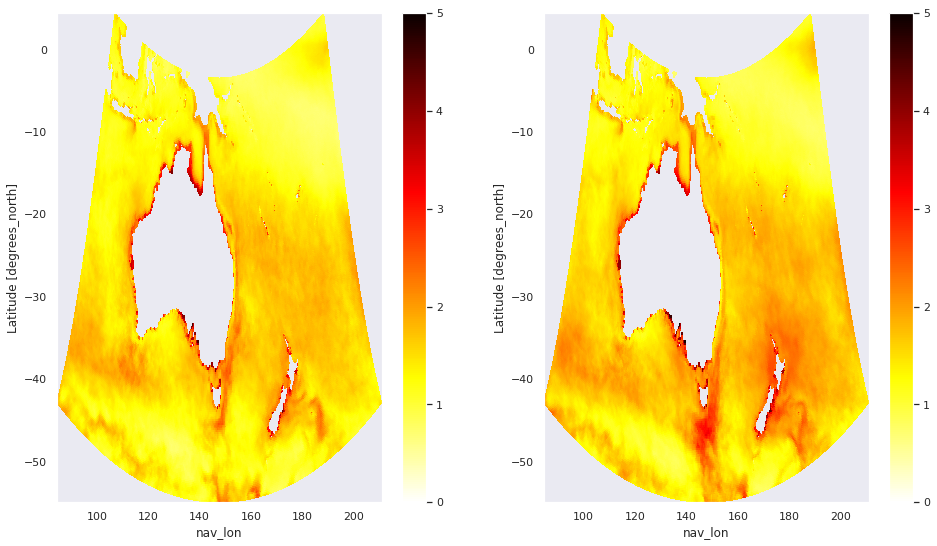

In [52]:
f, (ax1, ax2) = plt.subplots(1, 2)
vmin, vmax = (0, 5)
maxPastSSTA.plot(cmap = 'hot_r', ax = ax1, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);
maxFutSSTA.plot(cmap = 'hot_r',ax = ax2, x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax);

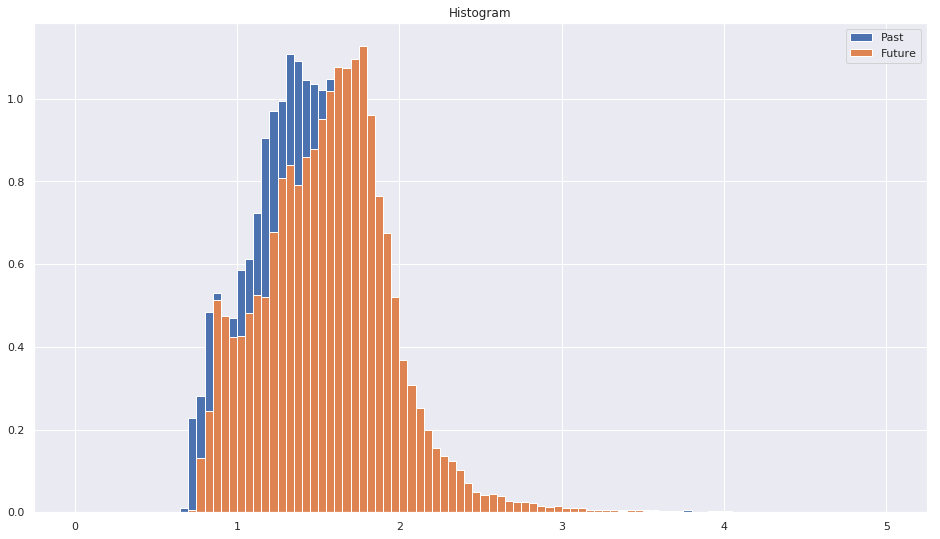

In [63]:
# Plots the frequencies/frequency density for each severity. 
bins = np.linspace(0, 5, 101)

# True if plotting densities, false if you want just frequency
pltDens = True

#f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

maxPastSSTA.plot.hist(bins = bins, density = pltDens, label = 'Past')#, ax = ax1);
maxFutSSTA.plot.hist(bins = bins, density = pltDens, label = 'Future')#, ax = ax2);
plt.legend()
'''
ax1.set_title('Past Severity')
ax1.grid(True)
ax1.set_xlabel('Severity')

ax2.set_title('Future Severity');
ax2.grid(True);
ax2.set_xlabel('Severity');
''';

In [53]:
SSTA_diff = maxFutSSTA - maxPastSSTA

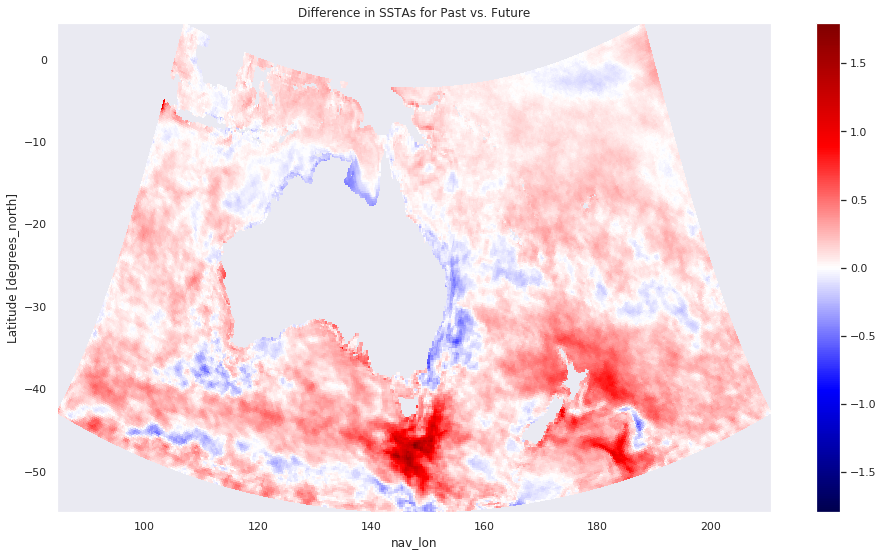

In [54]:
SSTA_diff.plot(cmap = 'seismic', x = 'nav_lon', y = 'nav_lat');
plt.title('Difference in SSTAs for Past vs. Future');

In [407]:
maxPastSSTA_seas = sstaPast.groupby('time_counter.season').max(dim = 'time_counter').compute()
maxFutSSTA_seas = sstaFut.groupby('time_counter.season').max(dim = 'time_counter').compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [466]:
maxSSTA_diff_seas = maxFutSSTA_seas - maxPastSSTA_seas
maxSSTA_diff_seas['nav_lon'] = maxSSTA_diff_seas['nav_lon'] % 360
maxSSTA_diff_seas = maxSSTA_diff_seas.isel(x = slice(5,-5), y = slice(5, -50))
# For some reason groupby gives the following order for the seasons:
seasons = {0:'Summer', 1:'Winter', 2:'Autumn', 3:'Spring'}

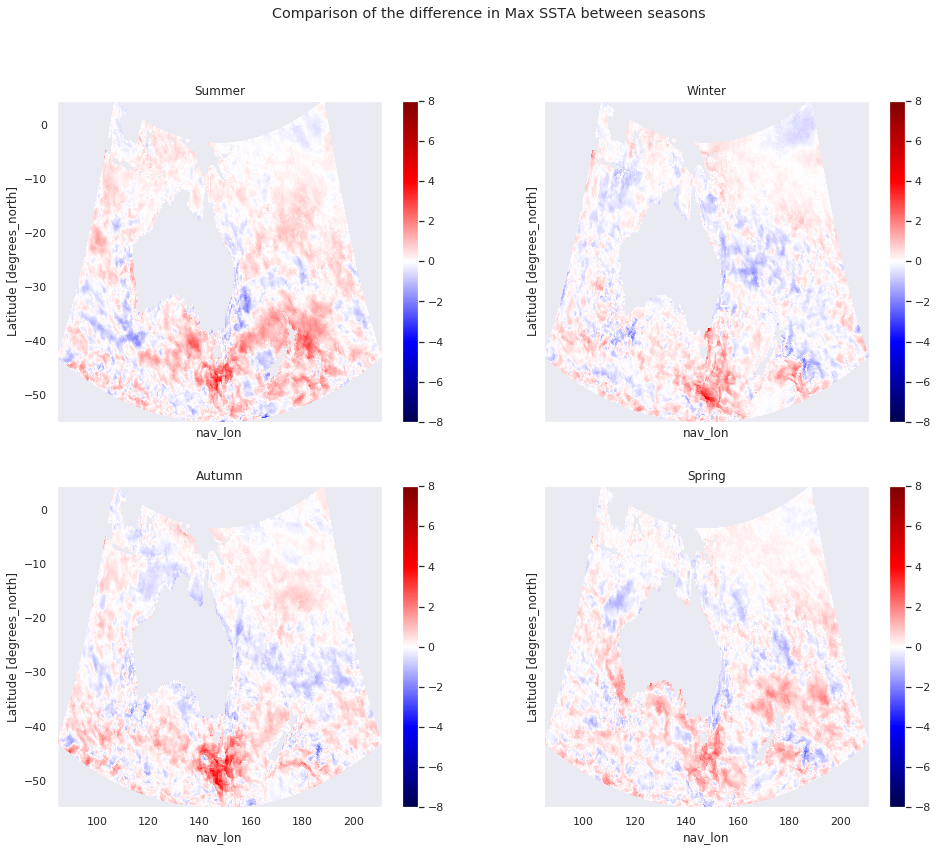

In [483]:
f, axes = plt.subplots(2,2, figsize = (16, 13), sharex = True, sharey = True)
f.suptitle('Comparison of the difference in Max SSTA between seasons')
vmin, vmax = (-8, 8)
i = 0
for ax in axes.flat:
    maxSSTA_diff_seas[i].plot(cmap = 'seismic', x='nav_lon', y ='nav_lat', ax = ax, vmin = vmin, vmax = vmax);
    ax.set_title(seasons[i])
    i += 1 
    
# Looking for negative values (implies future shallower than past)
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/maxSSTA_seas.png')

## Counting number of MHW days in each simulation

In [28]:
# Assigns a 1 for every mhw day, and sums along time dimension to calculate # of MHW days at each grid point.
pastDays = xr.where(pastMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).sum('time_counter')
#Removes areas where the sum receives 0, or where there are no MHW days ever. This is should be all land.
pastDays = xr.where(pastDays == 0, np.nan, pastDays).compute()

In [29]:
# Same as above
futDays = xr.where(futMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).sum('time_counter')
futDays = xr.where(futDays == 0, np.nan, futDays).compute()

In [30]:
print(futDays.sum().data/ pastDays.sum().data)
# Increase of 16% in MHW days!

1.1555577299555588


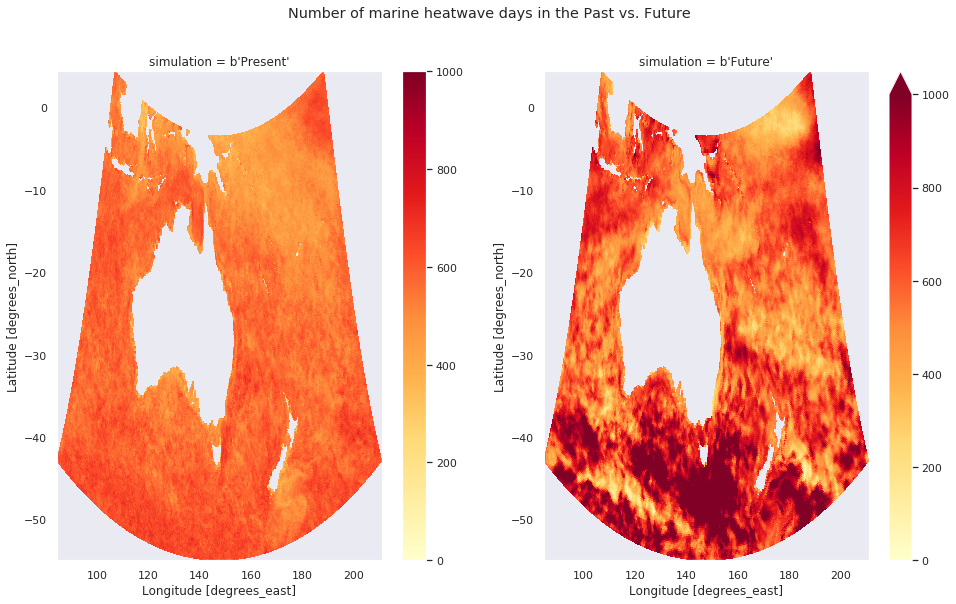

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2)
vmin, vmax = (0, 1000)
f.suptitle('Number of marine heatwave days in the Past vs. Future');
pastDays.plot(x = 'nav_lon', y = 'nav_lat', ax = ax1, vmin = vmin, vmax = vmax, cmap = 'YlOrRd');
futDays.plot(x = 'nav_lon', y = 'nav_lat', ax = ax2, vmin = vmin, vmax = vmax, cmap = 'YlOrRd');

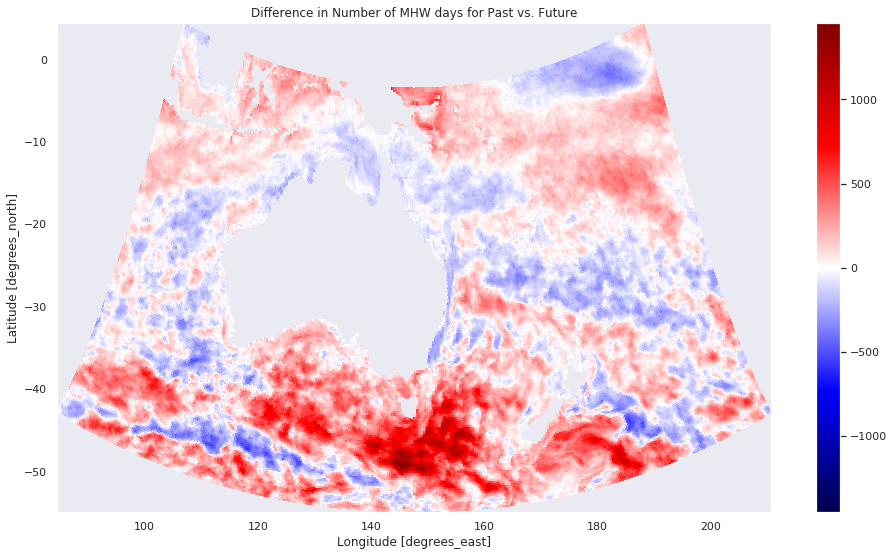

In [34]:
(futDays - pastDays).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic');
plt.title('Difference in Number of MHW days for Past vs. Future');

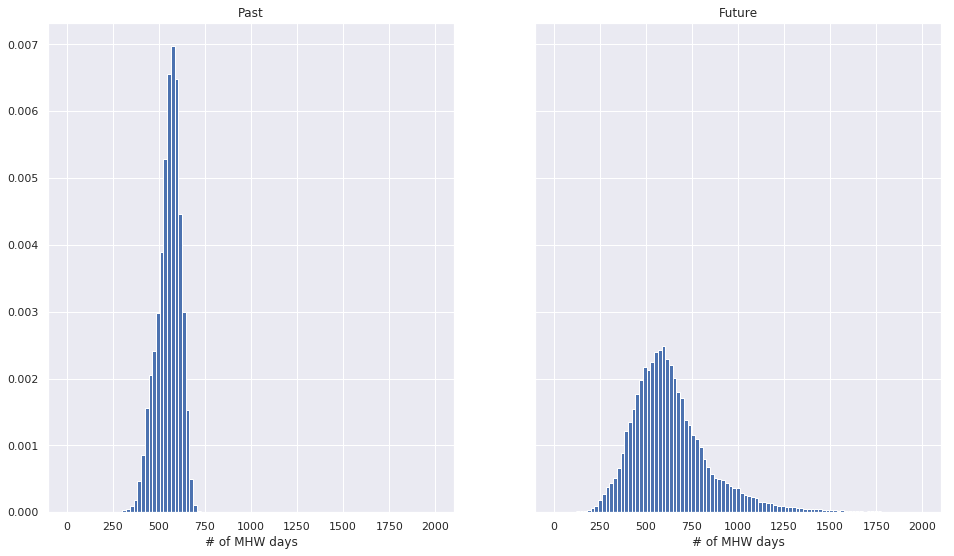

In [649]:
# Plots the frequencies/frequency density for # of days. 
bins = np.linspace(0,2000,100)

# True if plotting densities, false if you want just frequency
pltDens = True

f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)

pastDays.plot.hist(align = 'mid', density = pltDens, bins = bins, label = 'Past', ax = ax1);
futDays.plot.hist(align = 'mid', density = pltDens, bins = bins, label = 'Future', ax = ax2);
#plt.legend()

ax1.set_title('Past')
ax1.grid(True)
ax1.set_xlabel('# of MHW days')

ax2.set_title('Future');
ax2.grid(True);
ax2.set_xlabel('# of MHW days');

In [445]:
pastDays_seas = xr.where(pastMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).groupby('time_counter.season').sum('time_counter')
#Removes areas where the sum receives 0, or where there are no MHW days ever. This is should be all land.
pastDays_seas = xr.where(pastDays_seas == 0, np.nan, pastDays_seas).compute()

In [460]:
futDays_seas = xr.where(futMHW.isel(x = slice(5,-5), y = slice(5,-50)) > 0, 1, 0).groupby('time_counter.season').sum('time_counter')
#Removes areas where the sum receives 0, or where there are no MHW days ever. This is should be all land.
futDays_seas = xr.where(futDays_seas == 0, np.nan, futDays_seas).compute()

In [468]:
daysDiff_seas = futDays_seas - pastDays_seas

# For some reason groupby gives the following order for the seasons:
seasons = {0:'Summer', 1:'Winter', 2:'Autumn', 3:'Spring'}

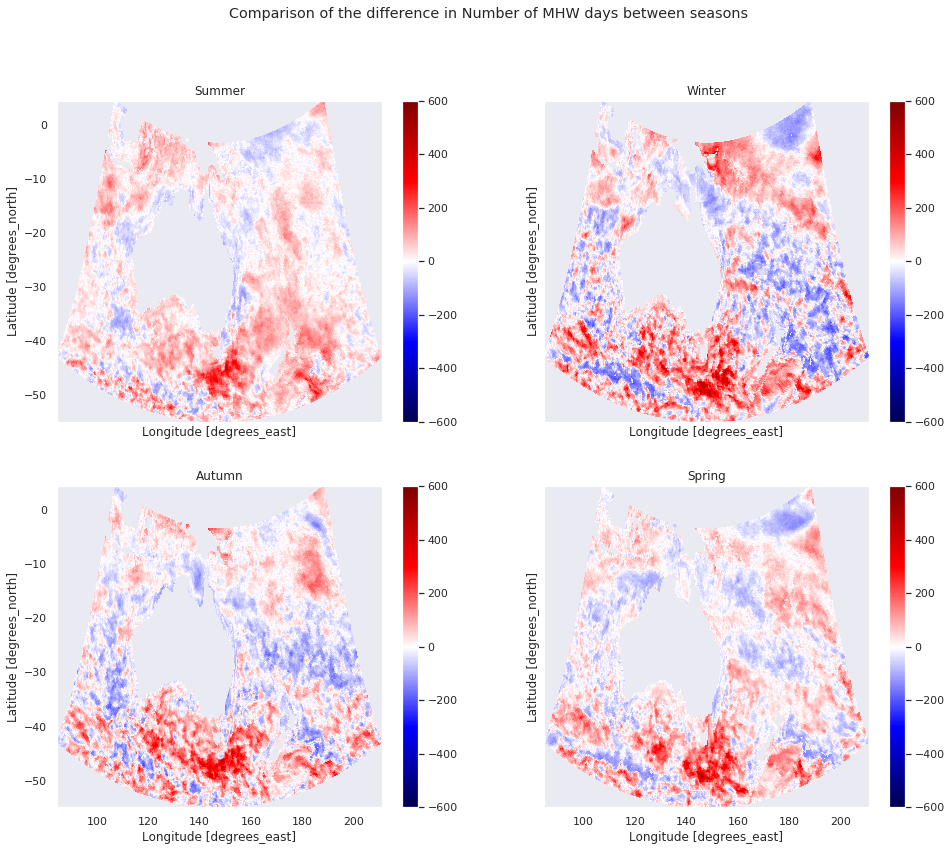

In [477]:
f, axes = plt.subplots(2,2, figsize = (16, 13), sharex = True, sharey = True)
f.suptitle('Comparison of the difference in Number of MHW days between seasons')
vmin, vmax = (-600, 600)
i = 0
for ax in axes.flat:
    daysDiff_seas[i].plot(cmap = 'seismic', x='nav_lon', y ='nav_lat', ax = ax, vmin = vmin, vmax = vmax);
    ax.set_title(seasons[i])
    i += 1 
    
#plt.savefig('/home/561/rm6294/Documents/maxSSTA_seas.png')

## Differences plotted together

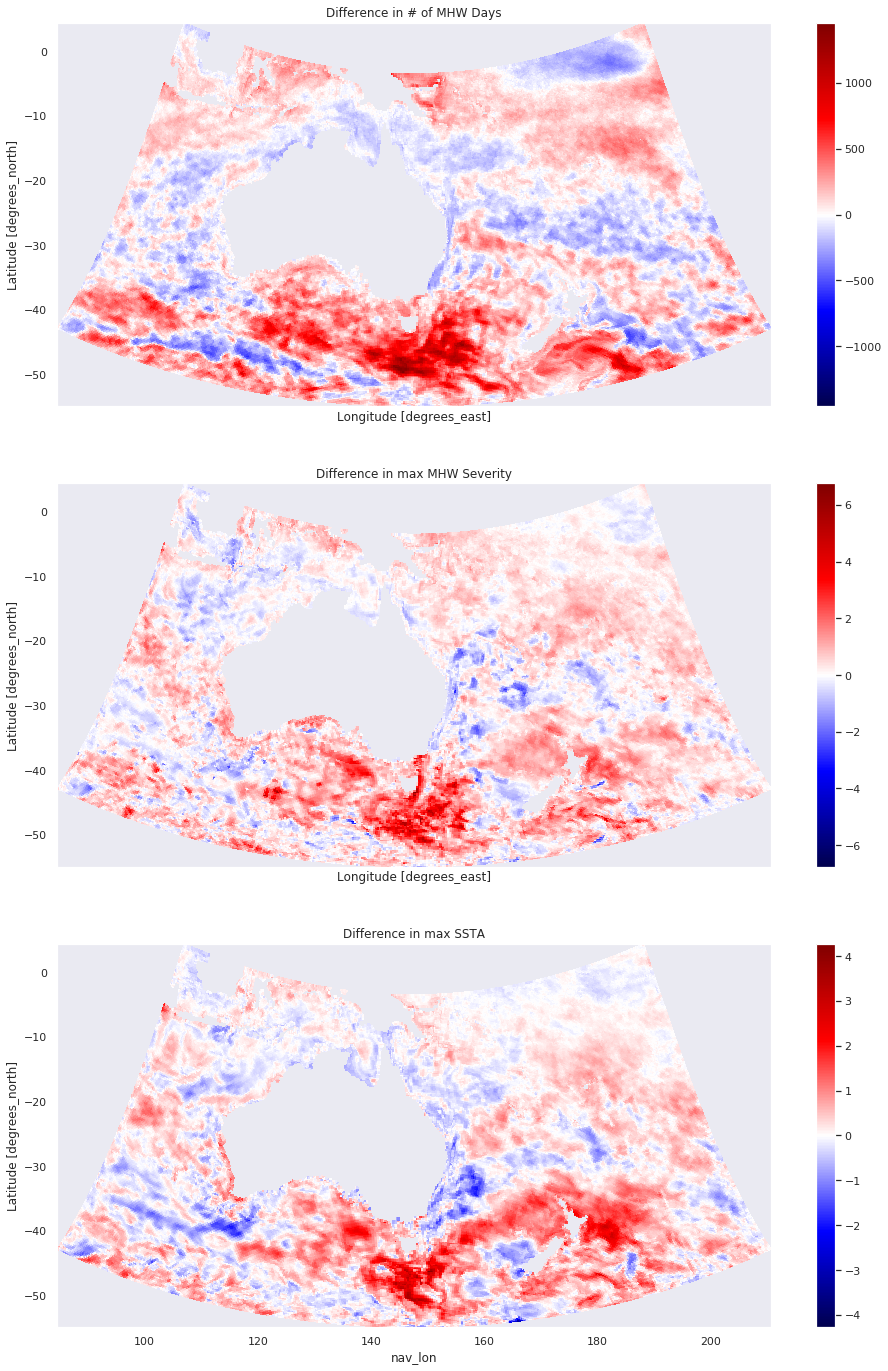

In [377]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex = True, figsize = (16,24))
#f.suptitle('Comparison of metrics in the Past vs. Future');

(futDays - pastDays).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', ax = ax1)
max_diff.plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', ax = ax2)
SSTA_diff.plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', ax = ax3)


ax1.set_title('Difference in # of MHW Days')
ax2.set_title('Difference in max MHW Severity')
ax3.set_title('Difference in max SSTA');
plt.savefig('/home/561/rm6294/Documents/diff_in_metrics.png')

## Calculating the difference in mean state

In [103]:
# files stored in Guillaumes directory
mean_dir = '/g/data1a/e14/gs9353/POST-PROCESS/ECLs/'
# We again slice away the troublesome regions. Also fix nav_lon
mean_file = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_T_2D_mean.nc').isel(x = slice(5,-5), y = slice(5,-50))
mean_file['nav_lon'] = mean_file['nav_lon'] % 360

In [98]:
EKE = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_Eddy_Kinetic_Energy.nc')
EKE['nav_lon'] = EKE['nav_lon'] % 360

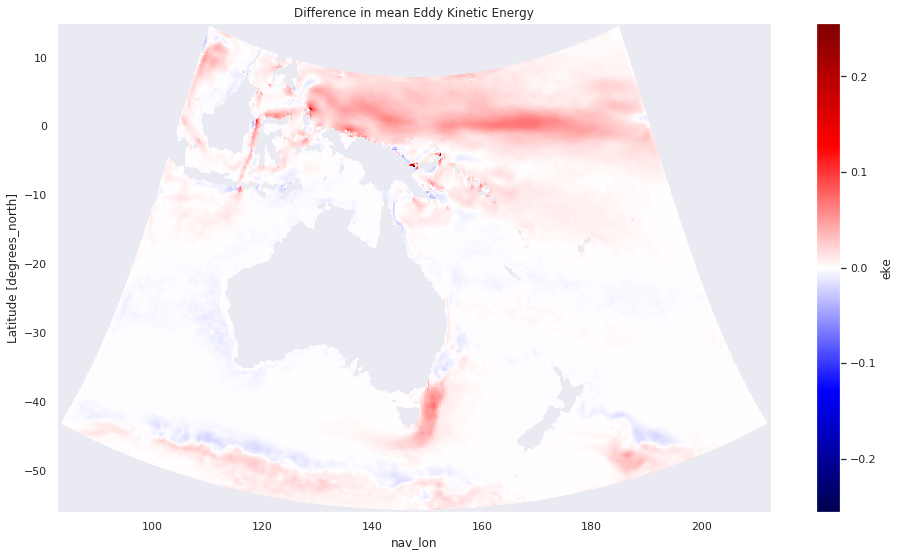

In [102]:
(EKE.sel(simulation = 'Future')['eke'] - EKE.sel(simulation = 'Present')['eke']).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic');
plt.title('Difference in mean Eddy Kinetic Energy');

In [526]:
sst_diff = sstFut - sstPast
max_sst_diff = sst_diff.isel(x = slice(5,-5), y = slice(5,-50)).max('time_counter').compute()
max_sst_diff['nav_lon'] = max_sst_diff['nav_lon'] % 360 

mean_sst = mean_file['tos']
mean_sst_diff = mean_sst.sel(simulation = 'Future') - mean_sst.sel(simulation = 'Present') 

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


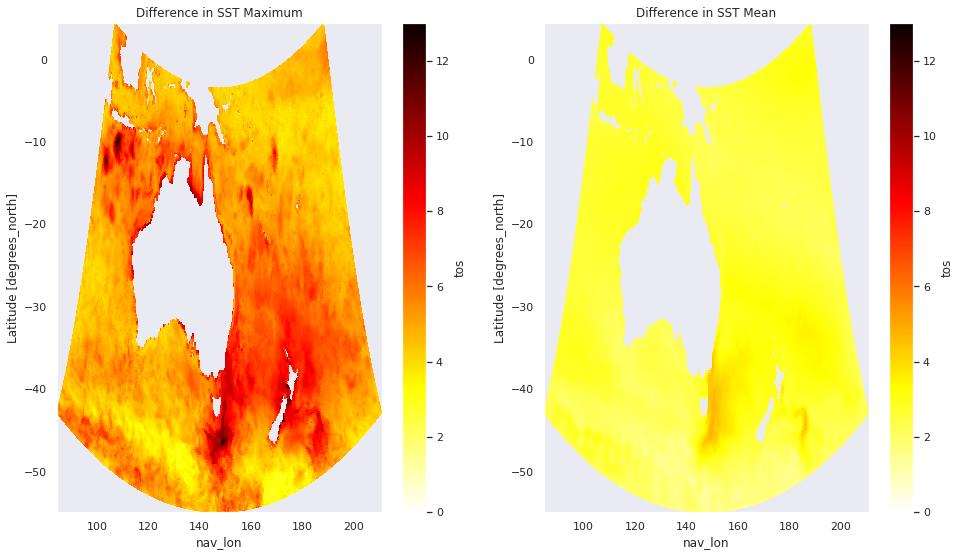

In [511]:
f, (ax1, ax2) = plt.subplots(1,2)
vmin, vmax = (0, 13) 

max_sst_diff.plot(cmap = 'hot_r', vmin = vmin, ax = ax1, x='nav_lon', y ='nav_lat', vmax = vmax)
mean_sst_diff.plot(cmap = 'hot_r', vmin = vmin, ax = ax2, x = 'nav_lon', y = 'nav_lat', vmax = vmax);

ax1.set_title('Difference in SST Maximum')
ax2.set_title('Difference in SST Mean');

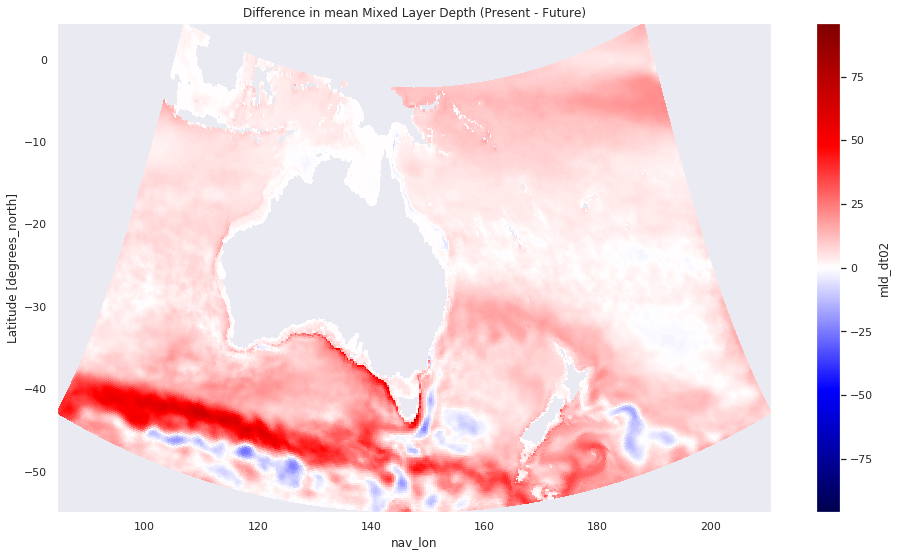

In [137]:
mld = mean_file['mld_dt02']
(mld.sel(simulation = 'Present') - mld.sel(simulation = 'Future')).plot(cmap = 'seismic', x = 'nav_lon', y = 'nav_lat');
plt.title('Difference in mean Mixed Layer Depth (Present - Future)');
# +ve means past deeper than future, -ve means future deeper than past
# We are expecting increased ocean stratification, so want +ve values

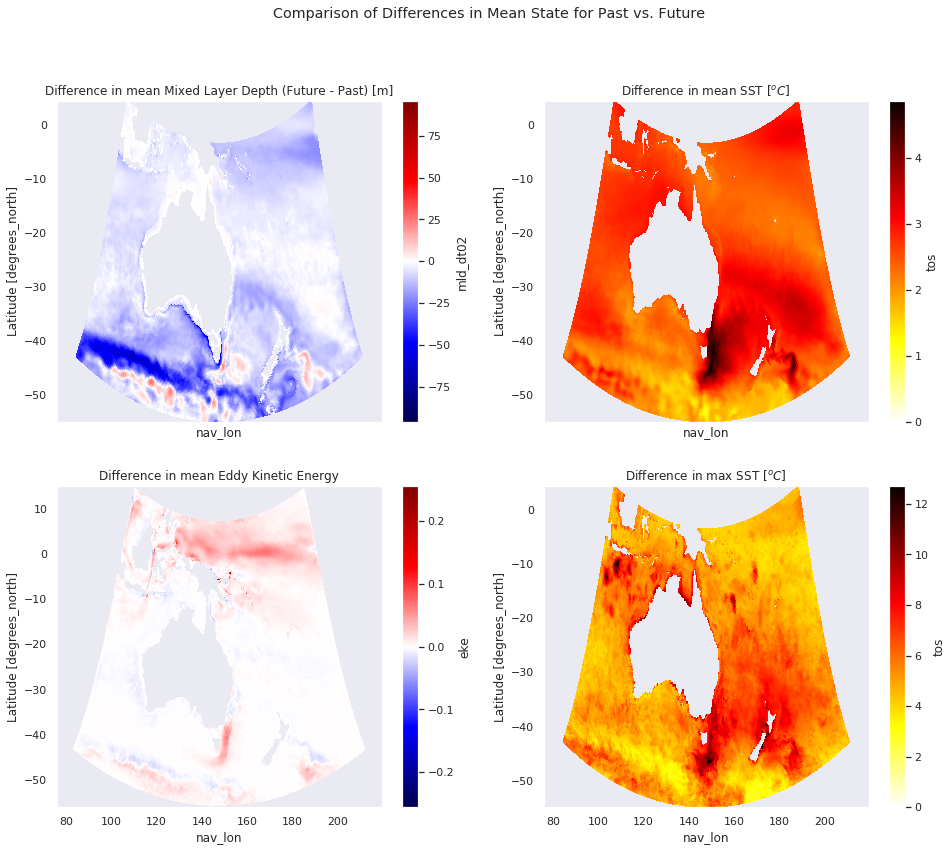

In [513]:
f, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, sharex = True, figsize = (16, 13))
f.suptitle('Comparison of Differences in Mean State for Past vs. Future');

(mld.sel(simulation = 'Future') - mld.sel(simulation = 'Present')).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', ax = ax11)
(EKE.sel(simulation = 'Future')['eke'] - EKE.sel(simulation = 'Present')['eke']).plot(x = 'nav_lon', y = 'nav_lat', cmap = 'seismic', ax = ax21)
max_sst_diff.plot(x = 'nav_lon', y = 'nav_lat', cmap = 'hot_r', ax = ax22, vmin = 0)
mean_sst_diff.plot(x = 'nav_lon', y = 'nav_lat', cmap = 'hot_r', ax = ax12, vmin = 0)


ax11.set_title('Difference in mean Mixed Layer Depth (Future - Past) [m]')
ax22.set_title('Difference in max SST [$^oC$]')
ax21.set_title('Difference in mean Eddy Kinetic Energy')
ax12.set_title('Difference in mean SST [$^oC$]');
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/diff_in_mean_states.png')

In [283]:
seas_file = xr.open_zarr(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_T_2D_seasonal_cycle.zarr')
seas_file['nav_lon'] = seas_file['nav_lon'] % 360 

In [284]:
mld_seas = seas_file['mld_dt02']

In [285]:
mld_seas_past = mld_seas.sel(simulation = 'Present').groupby_bins('dayofyear', [-31, 60, 152, 244, 335]).mean('dayofyear').compute()
mld_seas_fut = mld_seas.sel(simulation = 'Future').groupby_bins('dayofyear', [-31, 60, 152, 244, 335]).mean('dayofyear').compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [531]:
mld_seas_diff = mld_seas_fut - mld_seas_past
mld_seas_diff = mld_seas_diff.isel(x = slice(5,-5), y = slice(5,-50))

seasons = {0:'Summer', 1:'Autumn', 2:'Winter', 3:'Spring'}

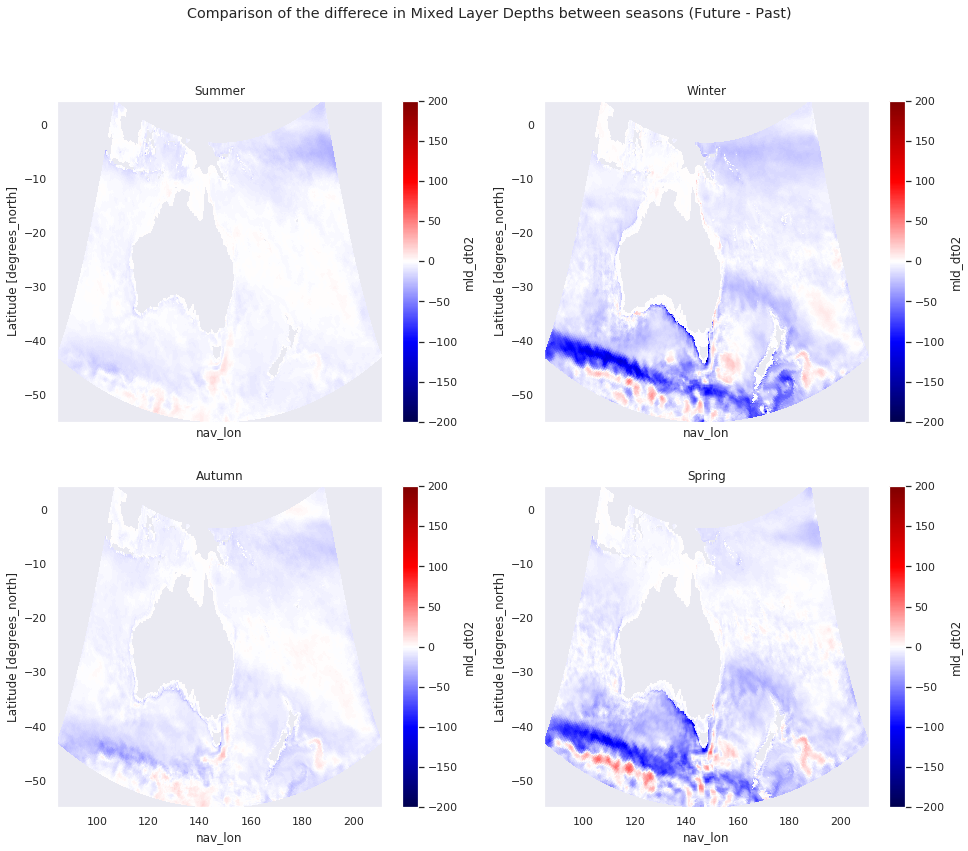

In [532]:
f, axes = plt.subplots(2,2, sharex = True, figsize = (16, 13))
# So that our plots are in line with the others: (swaps winter and autumn axes)
temp = axes[1,0]
axes[1,0] = axes[0,1]
axes[0,1] = temp
f.suptitle('Comparison of the differece in Mixed Layer Depths between seasons (Future - Past)')

vmin, vmax = (-200, 200)
i = 0
for ax in axes.flat:
    mld_seas_diff.isel(dayofyear_bins = i).plot(cmap = 'seismic', x='nav_lon', y ='nav_lat', ax = ax, vmin = vmin, vmax = vmax);
    ax.set_title(seasons[i])
    i += 1 
    
# Looking for positve values (implies future shallower than past)
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/mld_seasons.png')

##### Mean SST by season

In [515]:
sst_seas = seas_file['tos']

In [516]:
sst_seas_past = sst_seas.sel(simulation = 'Present').groupby_bins('dayofyear', [-31, 60, 152, 244, 335]).mean('dayofyear').compute()
sst_seas_fut = sst_seas.sel(simulation = 'Future').groupby_bins('dayofyear', [-31, 60, 152, 244, 335]).mean('dayofyear').compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [533]:
sst_seas_diff = sst_seas_fut - sst_seas_past
sst_seas_diff = sst_seas_diff.isel(x = slice(5,-5), y = slice(5,-50))

seasons = {0:'Summer', 1:'Autumn', 2:'Winter', 3:'Spring'}

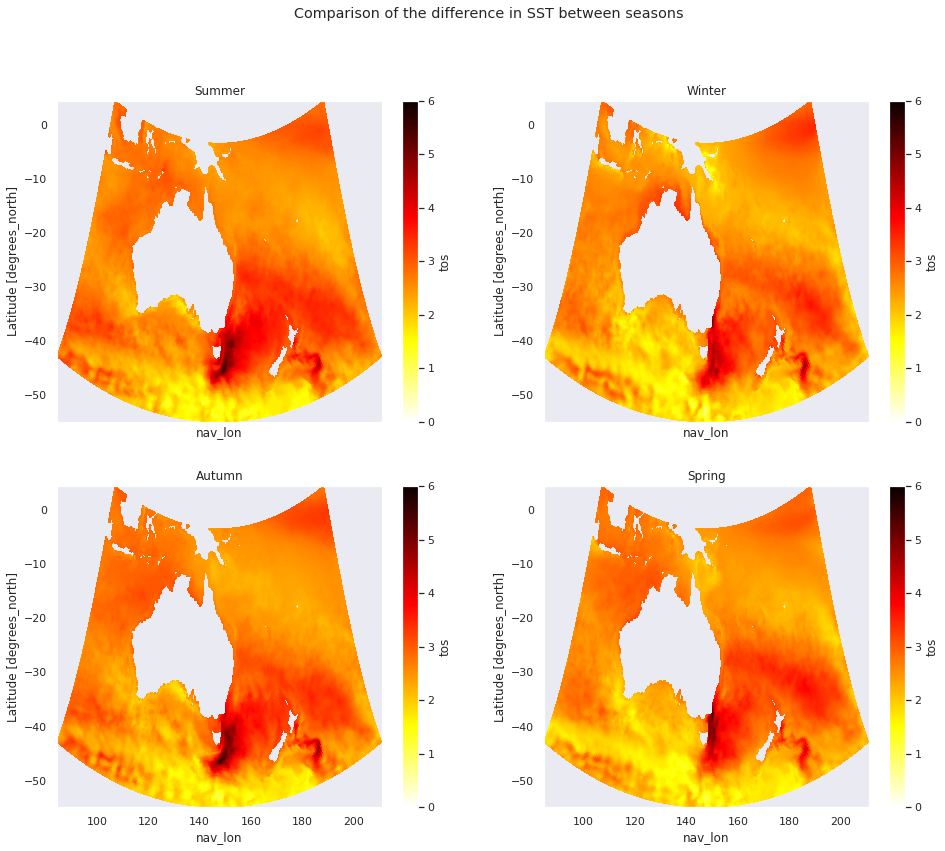

In [552]:
f, axes = plt.subplots(2,2, sharex = True, figsize = (16, 13))
# So that our plots are in line with the others: (swaps winter and autumn axes)
temp = axes[1,0]
axes[1,0] = axes[0,1]
axes[0,1] = temp
f.suptitle('Comparison of the difference in SST between seasons')

vmin, vmax = (0, 6)
i = 0
for ax in axes.flat:
    sst_seas_diff.isel(dayofyear_bins = i).plot(cmap = 'hot_r', x='nav_lon', y ='nav_lat', ax = ax, vmin = vmin, vmax = vmax);
    ax.set_title(seasons[i])
    i += 1 
    
# Looking for positve values (implies future shallower than past)
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/sst_seasons.png')

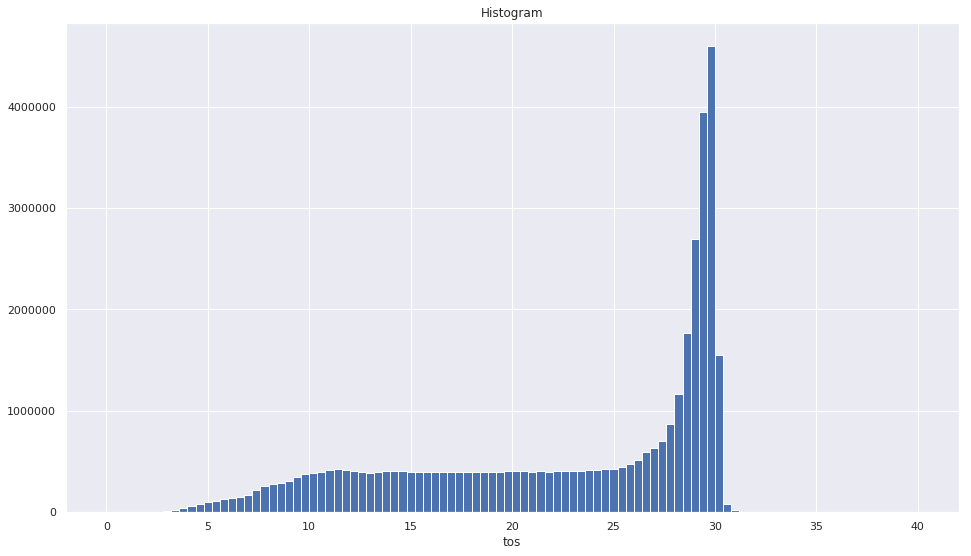

In [645]:
sst_seas.sel(simulation = 'Present').plot.hist(bins = np.linspace(0,40, 101));

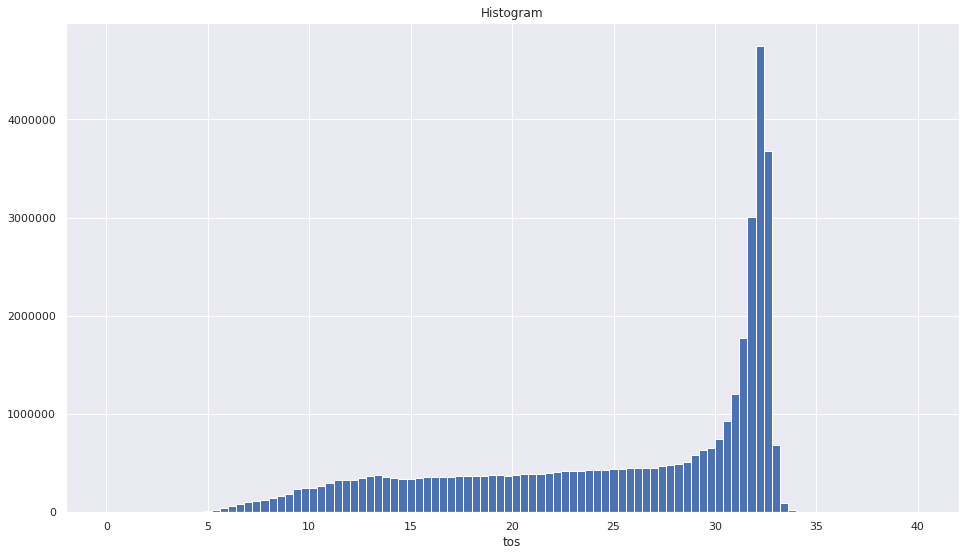

In [646]:
sst_seas.sel(simulation = 'Future').plot.hist(bins = np.linspace(0,40, 101));

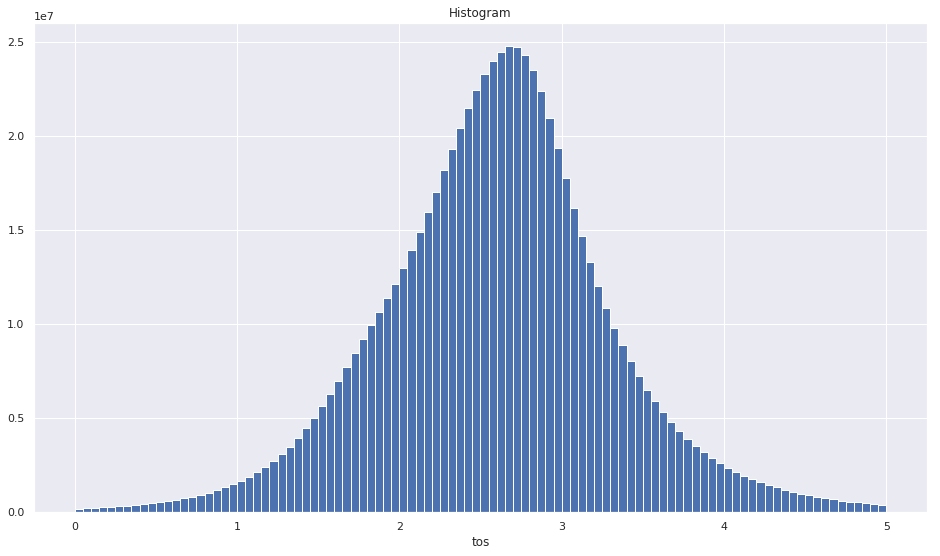

In [642]:
sst_diff.plot.hist(bins = np.linspace(0,5,101));

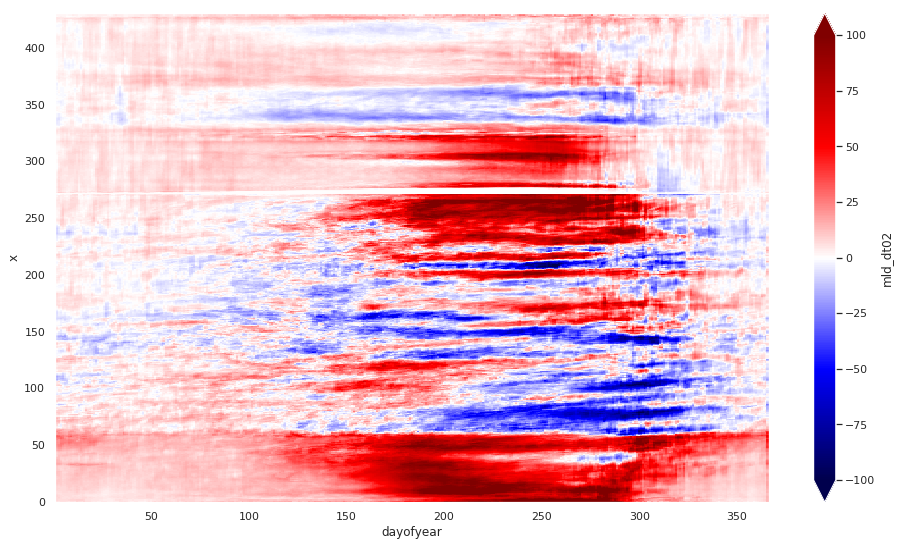

In [331]:
vmin, vmax = (-100, 100)
index = 20
(mld_seas.sel(simulation = 'Present') - mld_seas.sel(simulation = 'Future')).isel(y = index).transpose().plot(vmin = vmin, vmax = vmax, cmap = 'seismic');

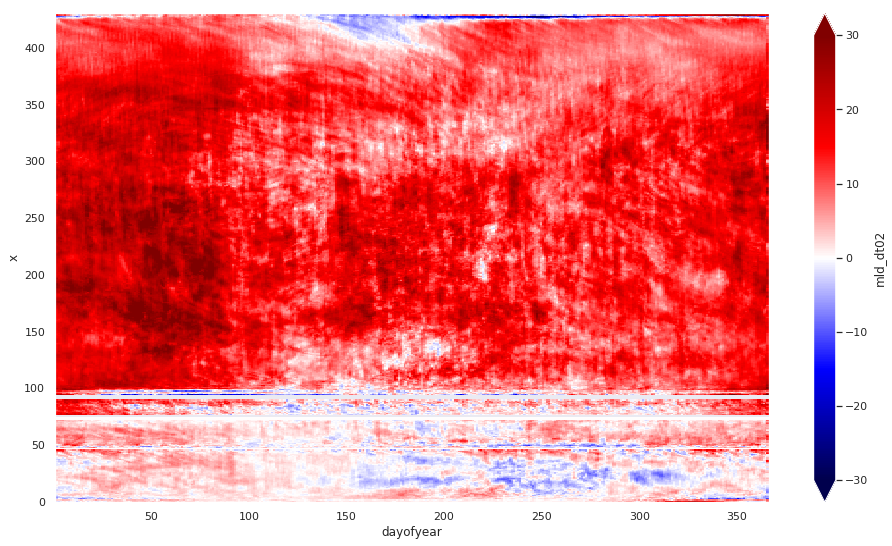

In [332]:
vmin, vmax = (-30, 30)
index = -20
(mld_seas.sel(simulation = 'Present') - mld_seas.sel(simulation = 'Future')).isel(y = index).transpose().plot(vmin = vmin, vmax = vmax, cmap = 'seismic');#mld_seas_fut.isel(y = index).plot(ax = ax2, vmin = vmin, vmax = vmax);

# Random Stuff 

In [44]:
xr.open_zarr(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_T_2D_seasonal_cycle.zarr')

<xarray.Dataset>
Dimensions:     (dayofyear: 366, simulation: 3, x: 431, y: 289)
Coordinates:
  * dayofyear   (dayofyear) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
    nav_lat     (y, x) float32 dask.array<shape=(289, 431), chunksize=(289, 431)>
    nav_lon     (y, x) float32 dask.array<shape=(289, 431), chunksize=(289, 431)>
  * simulation  (simulation) object 'Present' 'No Current Feedback' 'Future'
Dimensions without coordinates: x, y
Data variables:
    20d         (dayofyear, simulation, y, x) float32 dask.array<shape=(366, 3, 289, 431), chunksize=(1, 1, 289, 431)>
    blt         (dayofyear, simulation, y, x) float32 dask.array<shape=(366, 3, 289, 431), chunksize=(1, 1, 289, 431)>
    depti       (dayofyear, simulation, y, x) float32 dask.array<shape=(366, 3, 289, 431), chunksize=(1, 1, 289, 431)>
    mld_dt02    (dayofyear, simulation, y, x) float32 dask.array<shape=(366, 3, 289, 431), chunksize=(1, 1, 289, 431)>
    mldkz5      (dayofyear, simulation, y, x) float32 da

In [132]:
cfg = 'present_vs_future.ini'
# mld = Mixed Layer Depth
mld = now.io.open_nemo_griddata_from_zarr(cfg, grid='T')['mldr10_1']

In [133]:
mld_past = mld.sel(simulation = 'Present').chunk({'time_counter' : t_chunk, 'x' : x_chunk, 'y' : y_chunk})
mld_fut = mld.sel(simulation = 'Future').chunk({'time_counter' : t_chunk, 'x' : x_chunk, 'y' : y_chunk})

In [151]:
# doy = day of year. Grouping together days of the year and averaging across them
doy_pastAve = mld_past.groupby('time_counter.dayofyear').mean(dim = 'time_counter').compute()
doy_futAve = mld_fut.groupby('time_counter.dayofyear')`.mean(dim = 'time_counter').compute()

In [135]:
# Rolling mean acts to smooth doy calculations
rollingMean_past = doy_pastAve.rolling(dayofyear = 11, center = True).mean().compute()
rollingMean_fut = doy_futAve.rolling(dayofyear = 11, center = True).mean().compute()

ValueError: For window size 11, every chunk should be larger than 5, but the smallest chunk size is 1. Rechunk your array
with a larger chunk size or a chunk size that
more evenly divides the shape of your array.

In [168]:
doy_dif = mld_fut - mld_past

In [169]:
doy_dif

<xarray.DataArray 'mldr10_1' (time_counter: 6940, y: 289, x: 431)>
dask.array<shape=(6940, 289, 431), dtype=float32, chunksize=(365, 90, 120)>
Coordinates:
    nav_lat          (y, x) float32 dask.array<shape=(289, 431), chunksize=(90, 120)>
    nav_lon          (y, x) float32 dask.array<shape=(289, 431), chunksize=(90, 120)>
  * time_counter     (time_counter) datetime64[ns] 1990-01-01T12:00:00 ... 2008-12-31T12:00:00
    time_maximum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(365,)>
    time_minimum_1d  (time_counter) datetime64[ns] dask.array<shape=(6940,), chunksize=(365,)>
Dimensions without coordinates: y, x

In [156]:
max_doy_dif = doy_dif.max(dim = 'time_counter').compute()
min_doy_dif = doy_dif.min(dim = 'time_counter').compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [163]:
mean_doy_dif = doy_dif.mean(dim = 'time_counter').compute()

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


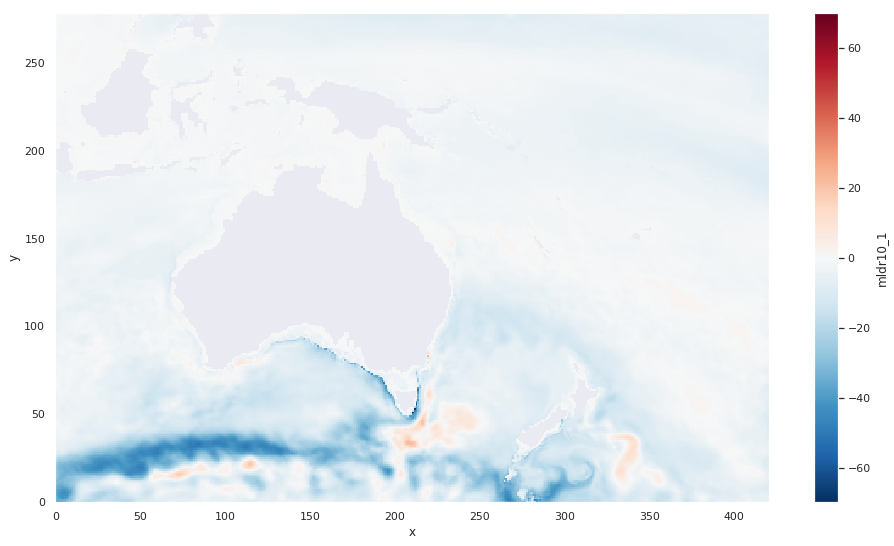

In [167]:
mean_doy_dif.isel(x = slice(5,-5), y = slice(5,-5)).plot();

In [146]:
max_doy_dif.plot()

<xarray.DataArray 'mldr10_1' (y: 289, x: 431)>
dask.array<shape=(289, 431), dtype=float32, chunksize=(90, 120)>
Coordinates:
    nav_lat  (y, x) float32 dask.array<shape=(289, 431), chunksize=(90, 120)>
    nav_lon  (y, x) float32 dask.array<shape=(289, 431), chunksize=(90, 120)>
Dimensions without coordinates: y, x

## Scaled Histogram Attempt 

In [595]:
len(max_diff.isel(y = 1)['nav_lat'][1:])

420

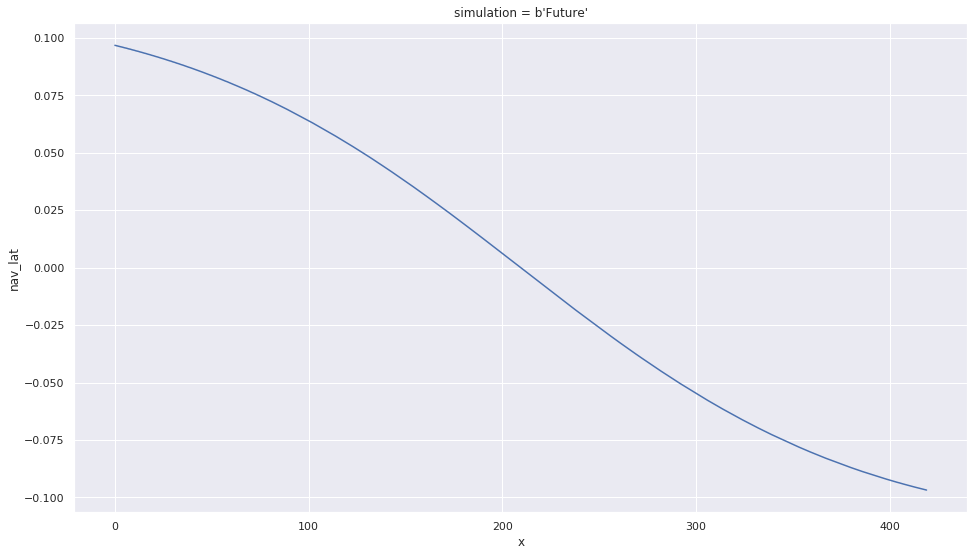

In [607]:
(max_diff.isel(y = 1)['nav_lat'][0:-1] - max_diff.isel(y = 1)['nav_lat'][1:]).plot()

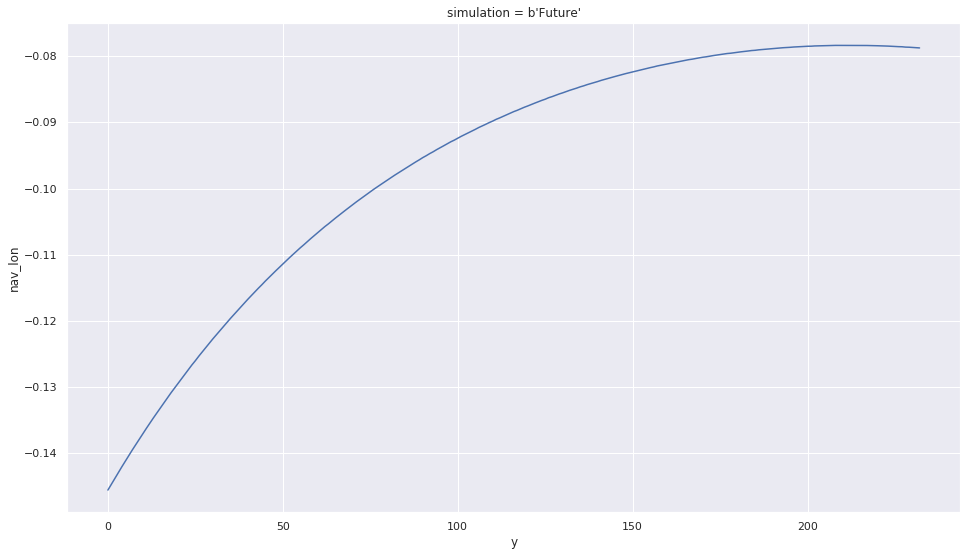

In [611]:
(max_diff.isel(x = 1)['nav_lon'][0:-1] - max_diff.isel(x = 1)['nav_lon'][1:]).plot();

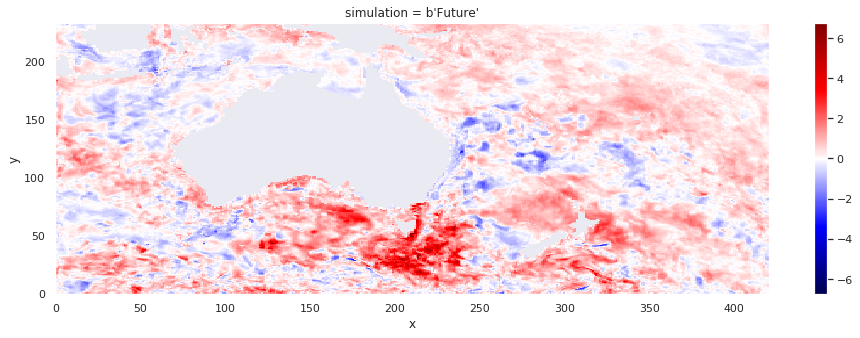

In [583]:
max_diff.plot(figsize = (16,5), cmap = 'seismic');

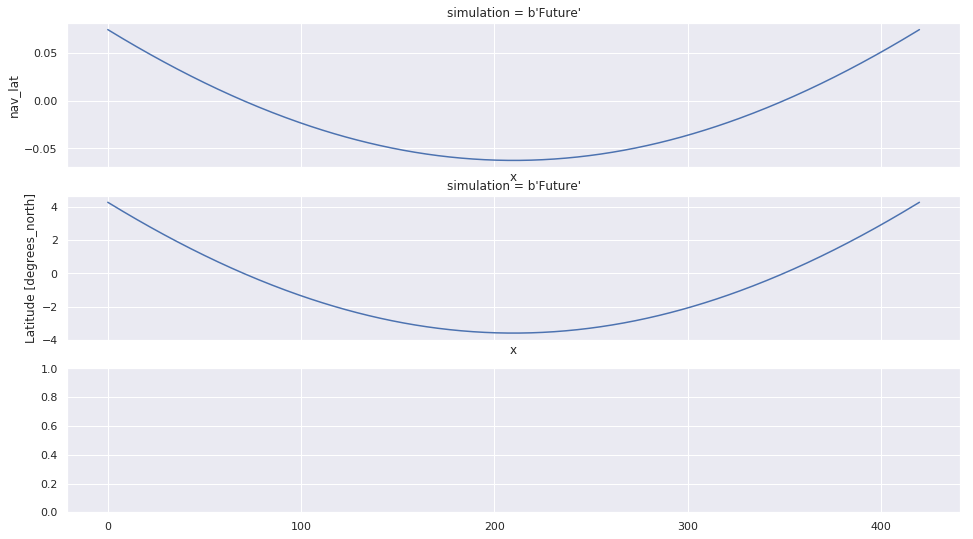

In [570]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex = True)
radians(max_diff.isel(y = -1)['nav_lat']).plot(ax = ax1);
(max_diff.isel(y = -1)['nav_lat']).plot(ax = ax2);
#np.sin(radians(max_diff.isel(y = -1)['nav_lat'])).plot(ax = ax2);
#np.cos(radians(max_diff.isel(y = -1)['nav_lat'])).plot(ax = ax3);

In [615]:
a = xr.where(max_diff['nav_lat'] != 0, np.sin(np.radians(max_diff['nav_lat'])), 1)

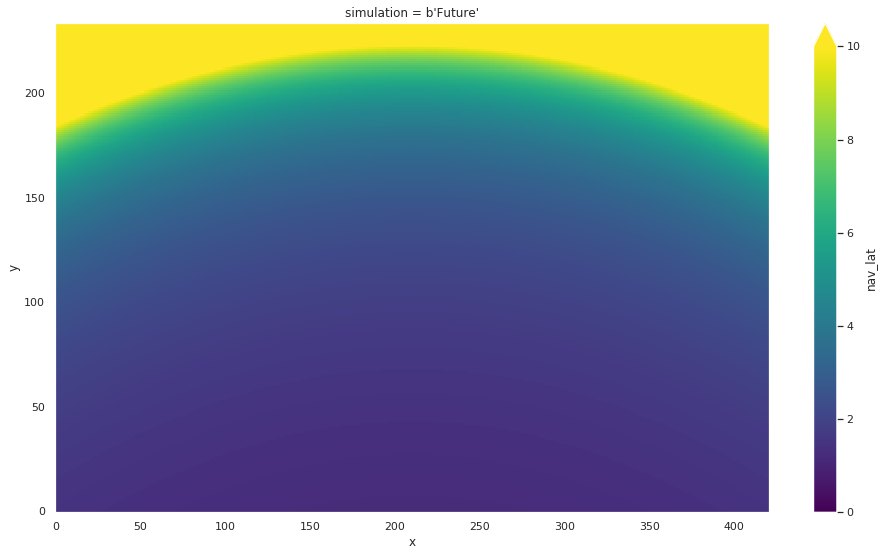

In [640]:
(1/np.abs(a)).plot(vmax = 10, vmin = 0)

In [586]:
scaled_max_diff = -1*max_diff / np.sin(np.radians(max_diff['nav_lat']))

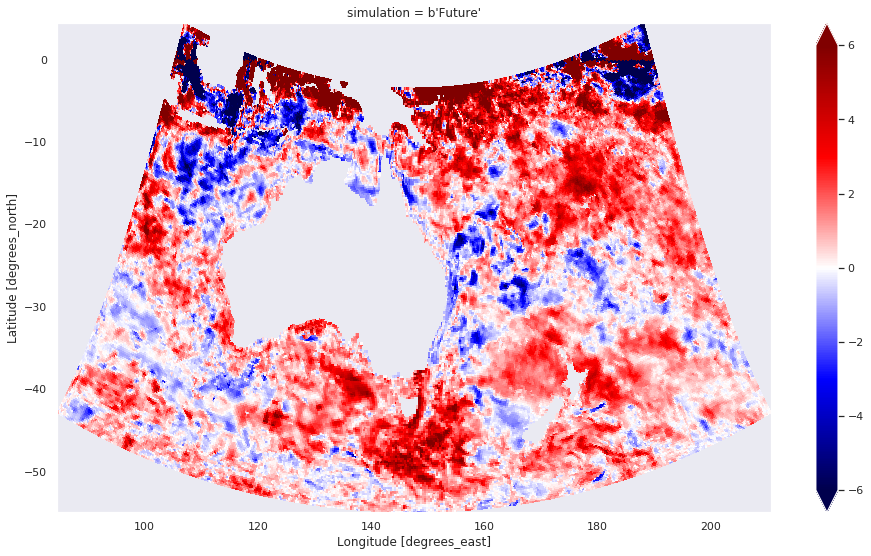

In [587]:
scaled_max_diff.plot(vmax = 6, vmin = -6, cmap = 'seismic', x = 'nav_lon', y = 'nav_lat');

In [110]:
scaled_max_diff = xr.where(max_diff != np.nan, -1 *max_diff / np.sin(np.radians(max_diff['nav_lat'])), np.nan)

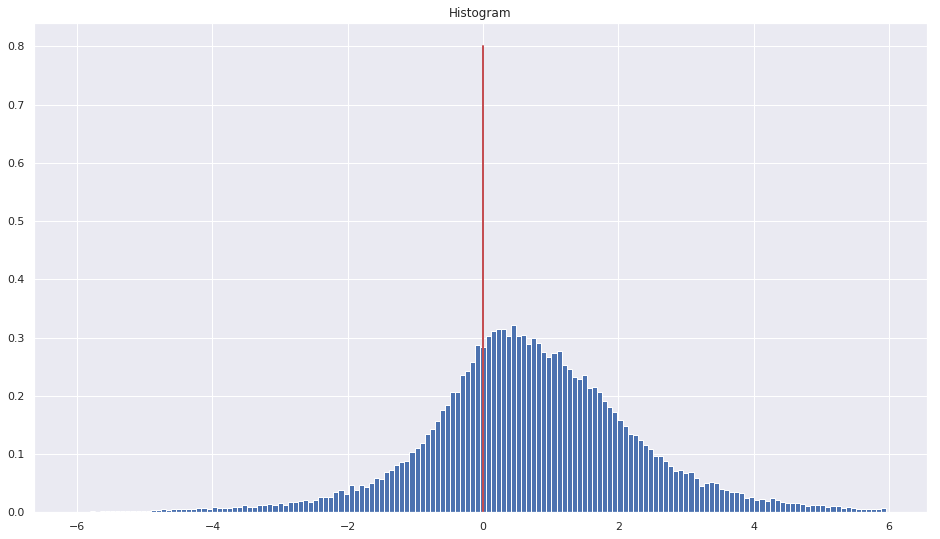

In [123]:
bins = np.linspace(-6, 6,161)
scaled_max_diff.isel(y = slice(0, -30)).plot.hist(align = 'left',  bins = bins, density = True);
plt.plot(np.zeros(50), np.linspace(0, 0.8, 50), 'r', linewidth = 2);

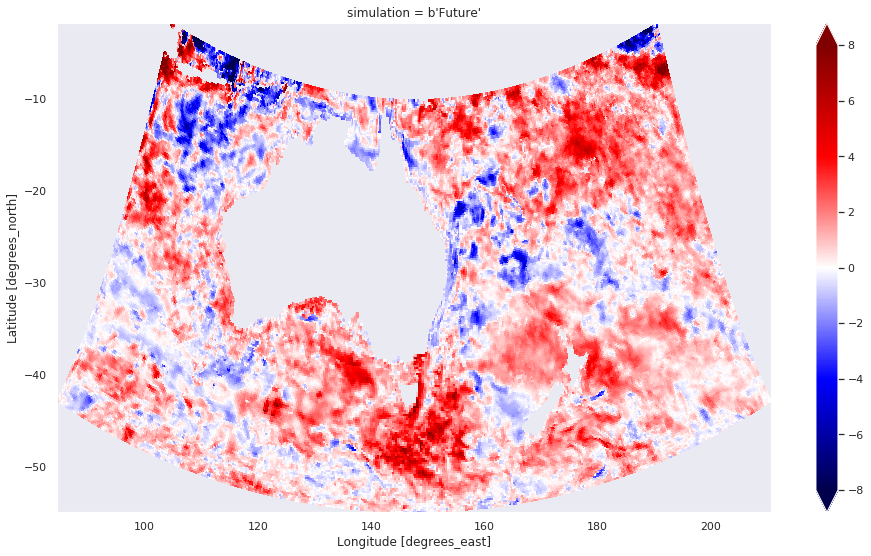

In [121]:
scaled_max_diff.isel(y = slice(0, -30)).plot(vmax = 8, vmin = -8, cmap = 'seismic', x = 'nav_lon', y = 'nav_lat');